In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding,Bidirectional
from gensim.models import KeyedVectors
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import jieba
import re
import numpy as np

In [2]:
cn_model=KeyedVectors.load_word2vec_format('sgns.zhihu.bigram',binary=False,unicode_errors="ignore")

In [3]:
def read_csv():
    text_csv=pd.read_csv('online_shopping_10_cats.csv')
    text_csv=text_csv.dropna()
    print(text_csv.shape)
    cat=text_csv['cat']
    label=text_csv['label']
    review=text_csv['review']
    cat=OneHotEncoder().fit_transform(LabelEncoder().fit_transform(cat).reshape(-1,1))
    label=OneHotEncoder().fit_transform(LabelEncoder().fit_transform(label).reshape(-1,1))
    reviews=[]
    for text in review:
        txt=re.sub("[\s+\.．【】：\!\/_,$%^*\(\)+\"\']+|[+—！，。？~～@#￥%……&*（） 、；│“ ”`?《》]+","",text)
        cut_list=[i for i in jieba.cut(txt)]
        for i,word in enumerate(cut_list):
            try:
                cut_list[i]=cn_model.key_to_index[word]
            except KeyError:
                cut_list[i]=0
                pass
        if cut_list==[]:cut_list=[0]
        reviews.append(cut_list)
    return cat,label,reviews

In [4]:
classes,evaluate,text=read_csv()

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


(62773, 3)


Loading model cost 0.521 seconds.
Prefix dict has been built successfully.


In [5]:
lens=[len(i) for i in text]
max(lens)

1459

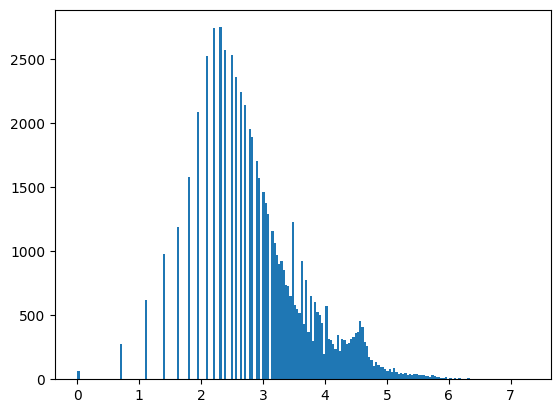

In [6]:
plt.hist(np.log(lens),bins=200)
plt.show()

In [7]:
max_tokens=np.mean(lens)+2*np.std(lens)
max_tokens=int(max_tokens)
max_tokens

113

In [8]:
np.sum(np.array(lens)<max_tokens)/len(lens)

0.9695251143007344

In [9]:
def reverse_tokens(tokens):
    text=''
    for i in tokens:
        if i!=0:
            text=text+cn_model.index_to_key[i]
        else:text=text+''
    return text

In [10]:
embedding_dim=300

num_words=50000
embedding_matrix=np.zeros((num_words,embedding_dim))

for i in range(num_words):
    embedding_matrix[i,:]=cn_model[cn_model.index_to_key[i]]
embedding_matrix=embedding_matrix.astype('float32')

In [11]:
text=pad_sequences(text,maxlen=max_tokens,padding='pre',truncating='pre')
text[text>=num_words]=0

In [12]:
text.shape

(62773, 113)

In [13]:
classes=classes.toarray()
evaluate=evaluate.toarray()

In [14]:
x_class_train,x_class_test,y_class_train,y_class_test=train_test_split(text,classes,test_size=0.2)

In [15]:
type(x_class_train),type(y_class_train)

(numpy.ndarray, numpy.ndarray)

In [16]:
x_class_train.shape,x_class_test.shape,y_class_train.shape,y_class_test.shape,max_tokens,embedding_matrix.shape

((50218, 113), (12555, 113), (50218, 10), (12555, 10), 113, (50000, 300))

In [115]:
model=Sequential()

In [116]:
model.add(Embedding(num_words,embedding_dim,weights=[embedding_matrix],input_length=max_tokens,trainable=False))
model.add(Bidirectional(LSTM(units=64,return_sequences=True)))
model.add(LSTM(units=16,return_sequences=False))
model.add(Dense(10,activation='sigmoid'))

In [117]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 113, 300)          15000000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 113, 128)          186880    
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                170       
Total params: 15,196,330
Trainable params: 196,330
Non-trainable params: 15,000,000
_________________________________________________________________


In [35]:
checkpoint=ModelCheckpoint("epoch-{epoch:02d}-val_loss{val_loss:.3f}-val_accuracy{val_accuracy:.3f}.hdf5",monitor='accuracy',save_best_only=True,save_weights_only=True)

In [36]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [37]:
x_class_train.shape,y_class_train.shape

((50218, 113), (50218, 10))

In [38]:
history=model.fit(x_class_train,y_class_train,validation_split=0.2,epochs=12,batch_size=32,callbacks=[checkpoint])

Epoch 1/12
1256/1256 [==============================] - 168s 131ms/step - loss: 0.2489 - accuracy: 0.4492 - val_loss: 0.1783 - val_accuracy: 0.7186
Epoch 2/12
1256/1256 [==============================] - 160s 127ms/step - loss: 0.1320 - accuracy: 0.7952 - val_loss: 0.1098 - val_accuracy: 0.8078
Epoch 3/12
1256/1256 [==============================] - 163s 130ms/step - loss: 0.0914 - accuracy: 0.8338 - val_loss: 0.0868 - val_accuracy: 0.8343
Epoch 4/12
1256/1256 [==============================] - 167s 133ms/step - loss: 0.0741 - accuracy: 0.8593 - val_loss: 0.0788 - val_accuracy: 0.8553
Epoch 5/12
1256/1256 [==============================] - 164s 131ms/step - loss: 0.0619 - accuracy: 0.8867 - val_loss: 0.0698 - val_accuracy: 0.8642
Epoch 6/12
1256/1256 [==============================] - 167s 133ms/step - loss: 0.0522 - accuracy: 0.9043 - val_loss: 0.0694 - val_accuracy: 0.8694
Epoch 7/12
1256/1256 [==============================] - 168s 134ms/step - loss: 0.0451 - accuracy: 0.9151 - val_

In [71]:
loss=history.history['loss']
val_loss=history.history['val_loss']
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

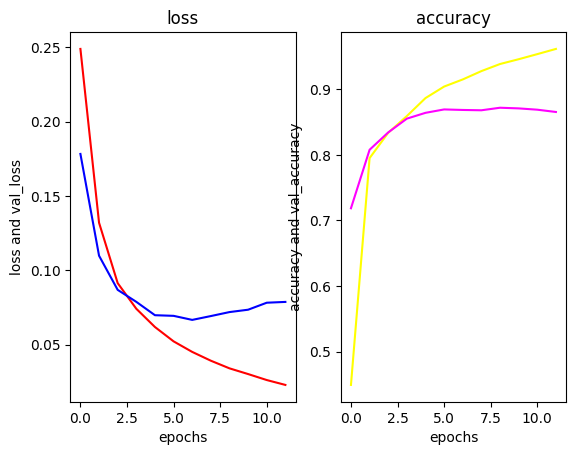

In [72]:
fg=plt.figure()
ax_loss=fg.add_subplot(121)
ax_loss.plot(loss,color='red')
ax_loss.plot(val_loss,color='blue')
ax_loss.set(title="loss", xlabel='epochs', ylabel='loss and val_loss')

ax_accuracy=fg.add_subplot(122)
ax_accuracy.plot(accuracy,color='yellow')
ax_accuracy.plot(val_accuracy,color='magenta')
ax_accuracy.set(title="accuracy", xlabel='epochs', ylabel='accuracy and val_accuracy')

plt.show()

In [45]:
model.evaluate(x_class_test,y_class_test)

393/393 [==============================] - 18s 45ms/step - loss: 0.0802 - accuracy: 0.8648


[0.08020760118961334, 0.8647550940513611]

In [59]:
y_class_info=['书籍','平板','手机','水果','洗发水','热水器','蒙牛','衣服','计算机','酒店']

In [103]:
new_model=Sequential()
for layer in model.layers[:-1]:
    new_model.add(layer)
new_model.add(Dense(2,activation='sigmoid'))

In [104]:
new_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 113, 300)          15000000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 113, 128)          186880    
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 15,196,194
Trainable params: 196,194
Non-trainable params: 15,000,000
_________________________________________________________________


In [84]:
evaluate.shape

(62773, 2)

In [85]:
new_x_train,new_x_test,new_y_train,new_y_test=train_test_split(text,evaluate,test_size=0.2)
new_x_train.shape,new_y_train.shape,new_x_test.shape,new_y_test.shape

((50218, 113), (50218, 2), (12555, 113), (12555, 2))

In [105]:
new_checkpoint=ModelCheckpoint("new_epoch-{epoch:02d}-val_loss{val_loss:.3f}-val_accuracy{val_accuracy:.3f}.hdf5",monitor='accuracy',save_best_only=True,save_weights_only=True)
new_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
new_history=new_model.fit(new_x_train,new_y_train,validation_split=0.2,epochs=10,batch_size=64,callbacks=[new_checkpoint])

Epoch 1/10
628/628 [==============================] - 469s 747ms/step - loss: 0.3027 - accuracy: 0.8819 - val_loss: 0.2408 - val_accuracy: 0.9134
Epoch 2/10
628/628 [==============================] - 454s 723ms/step - loss: 0.2232 - accuracy: 0.9163 - val_loss: 0.2055 - val_accuracy: 0.9249
Epoch 3/10
628/628 [==============================] - 459s 731ms/step - loss: 0.1922 - accuracy: 0.9305 - val_loss: 0.1993 - val_accuracy: 0.9280
Epoch 4/10
628/628 [==============================] - 456s 726ms/step - loss: 0.1713 - accuracy: 0.9391 - val_loss: 0.1963 - val_accuracy: 0.9283
Epoch 5/10
628/628 [==============================] - 450s 717ms/step - loss: 0.1503 - accuracy: 0.9476 - val_loss: 0.1940 - val_accuracy: 0.9300
Epoch 6/10
628/628 [==============================] - 456s 725ms/step - loss: 0.1280 - accuracy: 0.9567 - val_loss: 0.2009 - val_accuracy: 0.9321
Epoch 7/10
628/628 [==============================] - 489s 779ms/step - loss: 0.1058 - accuracy: 0.9657 - val_loss: 0.2218 -

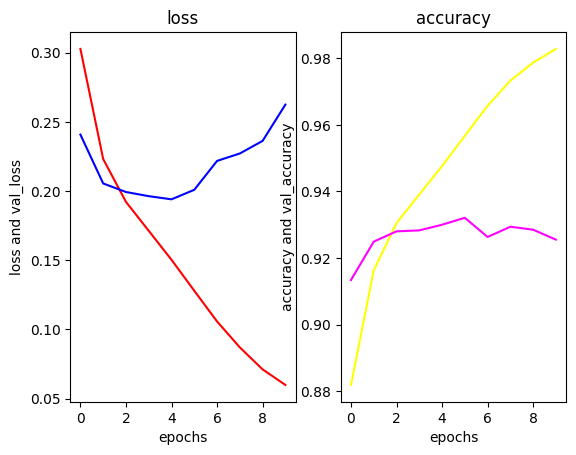

In [106]:
fg=plt.figure()
ax_loss=fg.add_subplot(121)
ax_loss.plot(new_history.history['loss'],color='red')
ax_loss.plot(new_history.history['val_loss'],color='blue')
ax_loss.set(title="loss", xlabel='epochs', ylabel='loss and val_loss')

ax_accuracy=fg.add_subplot(122)
ax_accuracy.plot(new_history.history['accuracy'],color='yellow')
ax_accuracy.plot(new_history.history['val_accuracy'],color='magenta')
ax_accuracy.set(title="accuracy", xlabel='epochs', ylabel='accuracy and val_accuracy')

plt.show()

In [119]:
# model.load_weights('epoch-09-val_loss0.072-val_accuracy0.872.hdf5')
# new_model.load_weights('new_epoch-08-val_loss0.227-val_accuracy0.929.hdf5')
for i in range(x_class_test.shape[0]//500):
    index=np.random.randint(x_class_test.shape[0],size=1)[0]
    pre_x=x_class_test[index]
    pre_x_text=reverse_tokens(pre_x)
    act_y=y_class_info[list(y_class_test[index]).index(max(y_class_test[index]))]
    pre=model.predict(np.array([pre_x]))[0]
    new_pre=new_model.predict(np.array([pre_x]))[0]
    pre_y=y_class_info[list(pre).index(max(pre))]
    new_pre_y=['负面','正面'][list(new_pre).index(max(new_pre))]
    print("{}:".format(i+1),pre_x_text,"类别:{},情感:{}".format(pre_y,new_pre_y),'\n')

1: 穿着太热根本体会不到是小心上当 类别:衣服,情感:负面 

2: 应该不是真货首先闻味道和在商场买的不一样其次洗完头之后没有顺滑的感觉之前很多次了都不是这样大家不要贪便宜吧 类别:洗发水,情感:负面 

3: 恶心的蒙牛 类别:蒙牛,情感:负面 

4: 好好好看电影 类别:平板,情感:正面 

5: 还不错一直购买的品牌 类别:平板,情感:正面 

6: 苹果很好色泽好看着就觉得不错不是特别相当到位好吃再来买京东配送速度快服务也到位 类别:水果,情感:正面 

7: 真的太差线头多开线 类别:衣服,情感:负面 

8: 条件一般台风天气那天房间不打折 类别:酒店,情感:负面 

9: 这个牌子的洗发水我一直都在用东西收到了是正品味道挺好闻的大爱 类别:洗发水,情感:正面 

10: 质量不错穿上很合适满意 类别:衣服,情感:正面 

11: 唯一就是房间设施略显陈旧卫生倒是做得非常好餐厅的鱼头味道不错价格也合适早餐单调南瓜很好吃不过一个房间的早餐我带着小朋友服务人员也人性化的免费的感觉还是不错的还有一点很重要这里的服务人员都很有礼貌在三星酒店来说很难得看得出酒店管理还是不错的当然最最重要的是价格很合适也许设备设施不如其它高星级的酒店但相比价格而言性价比还是蛮高的了下次来住假日饭店当然中彩票大奖后除外 类别:酒店,情感:正面 

12: 骂中国姑娘的态度不好更应该表现同胞姐妹的关爱而不是痛骂 类别:书籍,情感:负面 

13: 没收到货就显示订单已完成已签收什么意思嘛 类别:洗发水,情感:负面 

14: 令人惊讶的是宽带接口在床头下面需要把床拖出来才能够到最后我只能把电脑放在床头柜上自己坐在地上上网这是我碰到这样的情况2卫生间非常陈旧更的是毛巾已经边了居然还挂在那3早餐真的很差品种异常的少普通的煮鸡蛋还是服务员在那每人发一个而且我们8的时候所有桌子上都是乱七八糟的还没及时清理这样的早餐吃的让人恶心难怪看其他点评也提到早餐问题下次不会这家酒店了 类别:酒店,情感:负面 

15: 感觉面料不错尺寸大小都刚好穿着挺舒服 类别:衣服,情感:正面 

16: 好很好比商店的便宜好多而且用起来和商店的没区别希望卖家越做越好加油加油加油 类别:衣服,情感:正面 

17: 有点无法用型号小了又不能换 类别:手机,情感:负面 

18: 本次购物非常不满意显示实际不加拉链